In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def solsub(D,IHR,MM,LAT,LONG,AZ,IN,SC): 

##  following C.D. WHITEMAN and K.J. ALLWINE, Pacific Northwest Laboratory, Richland, WA 99352: 
##  Whiteman, C. D. and K. J. Allwine (1986). "Extraterrestrial solar radiation on inclined surfaces." Environmental Software 1(3): 164-169.

#-------------------------------------------------------
##  INPUTS: LONG =(-180 to 180 DEG), LAT=(-90 to 90 DEG),
#   AZ = slope azimuth angle (0 to 359), IN = slope in-
#   clination angle (0 to 90 DEG), SC = solar constant,
#   IHR = hour (0 to 23), MM = minute(00 to 59),
#   D = Julian Day
#-------------------------------------------------------
##  OUTPUTS:
#   OUT1 = Instantaneous radiation [W/m²]
#   OUT2 = Radiation on the slope [W/m²]
#   OUT3 = Sun's zenith angle [DEG]
#   OUT4 = Sun's azimuth angle [DEG]
#-------------------------------------------------------

#-- define constants
    ACOF = np.array([0.00839, -0.05391, -0.00154, -0.00222])
    BCOF = np.array([-0.12193, -0.15699, -0.00567, -0.00370])
    NDAY = np.array([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
    DZERO = 80
    ECCENT = 0.0167
    PI = np.pi
    # CALINT = 1.7

    RTOD = PI/180              # Radians to degrees
    DECMAX = (23 + 26/60)*RTOD # Declination
    OMEGA = (2*PI)/365
    ONEHR = 15*RTOD

#-- calculate Julian date -- no longer needed because D is a direct input
    #D = IDA + NDAY[MO-1]

#-- ratio of radius vectors squared
    OMD = OMEGA*D
    OMDZERO = OMEGA*DZERO
    RDVECSQ = 1/(1-ECCENT*np.cos(OMD))**2

#-- calculate declination of sun
    LONGSUN = OMEGA*(D-DZERO)+2*ECCENT*(np.sin(OMD)-np.sin(OMDZERO))
    DECLIN = np.arcsin(np.sin(DECMAX)*np.sin(LONGSUN))
    
    SDEC = np.sin(DECLIN)
    CDEC = np.cos(DECLIN)

#-- check for polar night/day
    ARG = ((PI/2)-abs(DECLIN))/RTOD

#-- keyboard
    if abs(LAT) > ARG:
        if ((LAT > 0) & (DECLIN < 0)) | ((LAT < 0) & (DECLIN > 0)):
            OUT1 = 0
            OUT2 = 0
            OUT3 = 0
            OUT4 = 0
            
    else: 
    #-- standard time meridian for site
        STDMRDN = round(LONG/15)*15
        STDMRDN = 0                   # UTC 
        LONGCOR = (LONG - STDMRDN)/15

    #-- compute time correction from equation of time
        B = 2*PI*(D-0.4)/365
        EM = 0

        for i in range(4):
            EM = EM + (BCOF[i]*np.sin((i+1)*B)+ACOF[i]*np.cos((i+1)*B))

    #-- time of solar noon
        TIMNOON = 12 -EM -LONGCOR
        AZSLO = AZ*RTOD
        INSLO = IN*RTOD

        SLAT = np.sin(LAT*RTOD)
        CLAT = np.cos(LAT*RTOD)
        CAZ  = np.cos(AZSLO)
        SAZ  = np.sin(AZSLO)
        SINC = np.sin(INSLO)
        CINC = np.cos(INSLO)

        T1 = IHR + MM/60
        H = ONEHR*(T1-TIMNOON)
        COSZ = SLAT*SDEC + CLAT*CDEC*np.cos(H)
  
        COSBETA = CDEC*((SLAT*np.cos(H))*(-CAZ*SINC)-np.sin(H)*(SAZ*SINC)+(CLAT*np.cos(H))*CINC) + SDEC*(CLAT*(CAZ*SINC)+SLAT*CINC)
    
        EXTRA = SC*RDVECSQ*COSZ
        EXTSLO = SC*RDVECSQ*COSBETA
        if EXTRA < 0: 
            EXTRA = 0
    
        if EXTRA <= 0 or EXTSLO < 0:
            EXTSLO = 0
    
        OUT2 = EXTSLO
    
        Z = np.arccos(COSZ)
        COSA = (SLAT*COSZ-SDEC)/(CLAT*np.sin(Z))

        if COSA < -1:
            COSA = -1
        elif COSA > 1:
            COSA = 1
    
    
        A = abs(np.arccos(COSA))

        if H < 0:
            A = -A
    
    
        OUT1 = EXTRA
        OUT3 = Z/RTOD
        OUT4 = A/RTOD + 180
        
        
        ## angle calculation: 
        # spherical to cartesian coordinats
        CART_SURF = [np.sin(AZ*PI/180)*np.cos(90-IN*PI/180),     np.sin(90-AZ*PI/180)*np.sin(IN*PI/180),     np.cos(IN*PI/180)]
        CART_SUN =  [np.sin(OUT3*PI/180)*np.cos(90-OUT4*PI/180), np.sin(OUT3*PI/180)*np.sin(90-OUT4*PI/180), np.cos(OUT3*PI/180)]

        # dot product of sun and surface vectors in cartesian coordinates
        DOT = CART_SUN[0]*CART_SURF[0]+CART_SUN[1]*CART_SURF[1]+CART_SUN[2]*CART_SURF[2]

        # theta = arccos(dot) i.e., CART_SURF . CART_SUN
        THETA_INCIDENT = 90-180*np.arccos(CART_SUN[0]*CART_SURF[0]+CART_SUN[1]*CART_SURF[1]+CART_SUN[2]*CART_SURF[2])/PI
            
        
    return OUT1,OUT2,OUT3,OUT4,THETA_INCIDENT

In [3]:
def returnFullModel(AZ,IN,LONG,LAT,START,END,TIMESTEP,SC): #START and END format should be: (YYYY,M,D), TTIMESTEP: (mins)
    
    # short function to convert from month/day to julian date
    def julian(MO,IDA):
        NDAY = np.array([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])

        return IDA + NDAY[MO-1]
    
    YEAR = START[0]
    D0 = julian(START[1],START[2])
    D1 = julian(END[1],END[2])
    
    Di = np.arange(D0,D1+1)
    
    SC   = 1361
    
    MMi   = np.arange(0,59,TIMESTEP)
    
    # create the datetime index
    k = 0
    
    OUTMATRIX = np.zeros((len(Di)*24*len(MMi),5))
    OUTINDEX = []

    for D in Di:
        for H in range(24):
            for MM in MMi:
                
                # first create a formatted string index later used for the dataframe
                s = '{}{}'.format(str(YEAR)[-2:],D)
                OUTINDEX.append(datetime.datetime.strptime(s+' {:02d}:{:02d}'.format(H,MM), '%y%j %H:%M').strftime("%Y-%m-%d %H:%M:%S"))
                
                # call the previously defined solsub function
                OUT = np.array(solsub(D,H,MM,LAT,LONG,AZ,IN,SC))
                OUTMATRIX[k] = OUT
                k+=1
    
    # create the dataframe:
    # first define empty dictionary
    PDOUT = {}
    # define the dataframe column labels
    LABELS = ["Instantaneous radiation [W/m²]",
              "Radiation on the slope [W/m²]",
              "Sun's zenith angle [DEG]",
              "Sun's azimuth angle [DEG]",
              "Angle between Sun and surface [DEG]"]
    
    for i,col in enumerate(LABELS):
        
        # populate the empty dictionary with key.value pairs
        PDOUT = {**PDOUT, col:OUTMATRIX[:,i]}
        
    # create the dataframe from the dictionary    
    d = pd.DataFrame(PDOUT, index = OUTINDEX)
    
    # convert the index to datetime index
    d.index = pd.to_datetime(d.index)
    
    return d         

In [4]:
### Enter coordinates of interest here: 

LONG = 11.385154
LAT  = 47.264260
SC   = 1361        # solar constant 

In [5]:
### Enter Azimuth and inclination here: 

North = returnFullModel(309,90,LONG,LAT,(2019,6,6),(2019,10,25),5,SC)
East  = returnFullModel(39, 90,LONG,LAT,(2019,6,6),(2019,10,25),5,SC)
South = returnFullModel(129,90,LONG,LAT,(2019,6,6),(2019,10,25),5,SC)
West  = returnFullModel(219,90,LONG,LAT,(2019,6,6),(2019,10,25),5,SC)
Top   = returnFullModel(1,  0, LONG,LAT,(2019,6,6),(2019,10,25),5,SC)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in arccos


In [6]:
North["orientation"]= "North"
East["orientation"] = "East"
South["orientation"]= "South"
West["orientation"] = "West"
Top["orientation"]  = "Top"

In [7]:
alldf = pd.concat([North, East, South, West, Top])

In [8]:
nozeros = alldf.loc[(alldf["Radiation on the slope [W/m²]"] > 0) & (alldf["Angle between Sun and surface [DEG]"] > 0)]

In [9]:
N_nozeros = nozeros.loc[(nozeros["orientation"] == "North")]
E_nozeros = nozeros.loc[(nozeros["orientation"] == "East")]
S_nozeros = nozeros.loc[(nozeros["orientation"] == "South")]
W_nozeros = nozeros.loc[(nozeros["orientation"] == "West")]
T_nozeros = nozeros.loc[(nozeros["orientation"] == "Top")]

In [10]:
print("Median NW (309°) = ",   '{:.2f}'.format(N_nozeros["Angle between Sun and surface [DEG]"].median()),"°, ", "std =", '{:.2f}'.format(N_nozeros["Angle between Sun and surface [DEG]"].std()))
print("Median NE (39°) = ",   '{:.2f}'.format(E_nozeros["Angle between Sun and surface [DEG]"].median()),"°, ", "std =", '{:.2f}'.format(E_nozeros["Angle between Sun and surface [DEG]"].std()))
print("Median SE (129°) = ",   '{:.2f}'.format(S_nozeros["Angle between Sun and surface [DEG]"].median()),"°, ", "std =", '{:.2f}'.format(S_nozeros["Angle between Sun and surface [DEG]"].std()))
print("Median SW (219°) = ",   '{:.2f}'.format(W_nozeros["Angle between Sun and surface [DEG]"].median()),"°, ", "std =", '{:.2f}'.format(W_nozeros["Angle between Sun and surface [DEG]"].std()))
print("Median Horizontal = ",   '{:.2f}'.format(T_nozeros["Angle between Sun and surface [DEG]"].median()),"°, ", "std =", '{:.2f}'.format(T_nozeros["Angle between Sun and surface [DEG]"].std()))

Median NW (309°) =  22.40 °,  std = 13.27
Median NE (39°) =  41.12 °,  std = 18.60
Median SE (129°) =  25.14 °,  std = 10.15
Median SW (219°) =  43.49 °,  std = 19.86
Median Horizontal =  31.76 °,  std = 18.33


In [11]:
medians = nozeros.groupby(["orientation"])["Angle between Sun and surface [DEG]"].median()
medians = medians.round(1)
medians = medians.reindex(index=["East","North", "South","West","Top"]) # to match with order in violinplots 

### changing "North, East, ..." to "NW (309°), ..." 

In [13]:
nozeros["orientation"] = nozeros["orientation"].replace(['North'],'NW (309°)')
nozeros["orientation"] = nozeros["orientation"].replace(['East'],'NE (39°)')
nozeros["orientation"] = nozeros["orientation"].replace(['South'],'SE (129°)')
nozeros["orientation"] = nozeros["orientation"].replace(['West'],'SW (219°)')
nozeros["orientation"] = nozeros["orientation"].replace(['Top'],'Horizontal')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

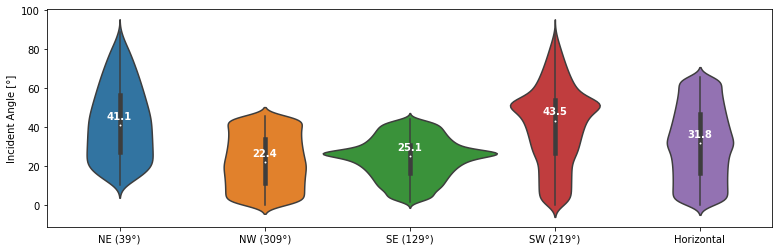

In [15]:
# and here we go: 

fig, ax = plt.subplots(figsize=[13,4])


violinplot = sns.violinplot(x="orientation", y="Angle between Sun and surface [DEG]", data=nozeros,
               order=['NE (39°)','NW (309°)', "SE (129°)","SW (219°)","Horizontal"], width=1.2)

vertical_offset = nozeros["Angle between Sun and surface [DEG]"].median() * 0.1 # offset from median for display
ax.set(xlabel = "", ylabel='Incident Angle [°]')

for xtick in violinplot.get_xticks():
    violinplot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',color='w',weight='semibold')

#plt.savefig('violin plot_5min.png', dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.2)
plt.show()